# Project

In [2]:
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from subprocess import check_output
from matplotlib.ticker import FuncFormatter
%matplotlib inline
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import sklearn 
import scipy.special as spsp
from scipy.optimize import minimize
import scipy.stats as spst

import warnings
warnings.simplefilter("ignore")

# 1. Input data

In [4]:
#raw data
df = pd.read_csv('H-1B_Disclosure_Data_FY2019.csv')
df.head()

/Users/lijiajie/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (15,16,17,29,30,42,52,54,55,56,58,59,60,62,63,64,66,67,68,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,ORIGINAL_CERT_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_BUSINESS_DBA,...,APPX_A_FIELD_OF_STUDY_3,APPX_A_DATE_OF_DEGREE_3,APPX_A_NO_OF_EXEMPT_WORKER_4,APPX_A_NAME_OF_INSTITUTION_4,APPX_A_FIELD_OF_STUDY_4,APPX_A_DATE_OF_DEGREE_4,APPX_A_NO_OF_EXEMPT_WORKER_5,APPX_A_NAME_OF_INSTITUTION_5,APPX_A_FIELD_OF_STUDY_5,APPX_A_DATE_OF_DEGREE_5
0,I-200-18269-520762,DENIED,9/26/2018,10/1/2018,NaN,H-1B,9/26/2018,9/26/2021,"NES GLOBAL, LLC",CANDACE ROMERO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I-200-18323-885516,DENIED,11/19/2018,11/26/2018,NaN,H-1B,11/27/2018,11/26/2021,UNIVERSITY OF TEXAS AT DALLAS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I-200-18323-882044,DENIED,11/19/2018,11/26/2018,NaN,H-1B,11/28/2018,11/27/2021,UNIVERSITY OF TEXAS AT DALLAS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I-200-18356-858057,DENIED,12/22/2018,12/27/2018,NaN,H-1B,1/1/2019,1/1/2022,BILLY R. WINGARD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I-200-19081-827349,CERTIFIED,3/22/2019,3/28/2019,NaN,H-1B,4/1/2019,4/1/2022,"COATES,BRIGHT & BAY LLC",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#pick useful features
h1b = df.iloc[:,:53]
h1b=h1b[h1b['CASE_STATUS']!='CERTIFIED-WITHDRAWN']

In [6]:
#calculate annual salary
h1b.dropna(subset = ['PREVAILING_WAGE', 'PW_UNIT_OF_PAY'], inplace = True)
def wage_convert(x):
    total = float(x['PREVAILING_WAGE'][1:].replace(",",''))
    unit = x['PW_UNIT_OF_PAY']
    if unit == 'Year':
        return total
    elif unit == 'Month':
        return total*12
    elif unit == 'Week':
        return total*52
    elif unit == 'Bi-Weekly':
        return total*26
    elif unit == 'Hour':
        return total*52*5*8
    
h1b['annual_salary'] = h1b.apply(wage_convert, axis = 1)

In [8]:
#convert date to datetime
h1b['CASE_SUBMITTED'] = pd.to_datetime(h1b['CASE_SUBMITTED'])
h1b['DECISION_DATE'] = pd.to_datetime(h1b['DECISION_DATE'])
h1b['EMPLOYMENT_START_DATE'] = pd.to_datetime(h1b['EMPLOYMENT_START_DATE'])
h1b['EMPLOYMENT_END_DATE'] = pd.to_datetime(h1b['EMPLOYMENT_END_DATE'])

# 2. Data Visualization

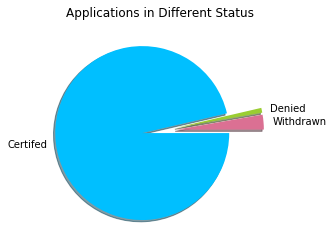

In [9]:
#applications in different status
certified=h1b[h1b['CASE_STATUS']=='CERTIFIED'].shape[0]
denied=h1b[h1b['CASE_STATUS']=='DENIED'].shape[0]
withdrawn=h1b[h1b['CASE_STATUS']=='WITHDRAWN'].shape[0]
values=[certified,denied,withdrawn]
colors=['deepskyblue','yellowgreen','palevioletred']
labels=['Certifed','Denied','Withdrawn']
explode=(0.2,0.2,0.2)
plt.pie(values, colors=colors,labels=labels,explode=explode, counterclock=False, shadow=True)
plt.title('Applications in Different Status')
plt.show()


Text(0.5, 0, 'Number of Certified Applications (x1000)')

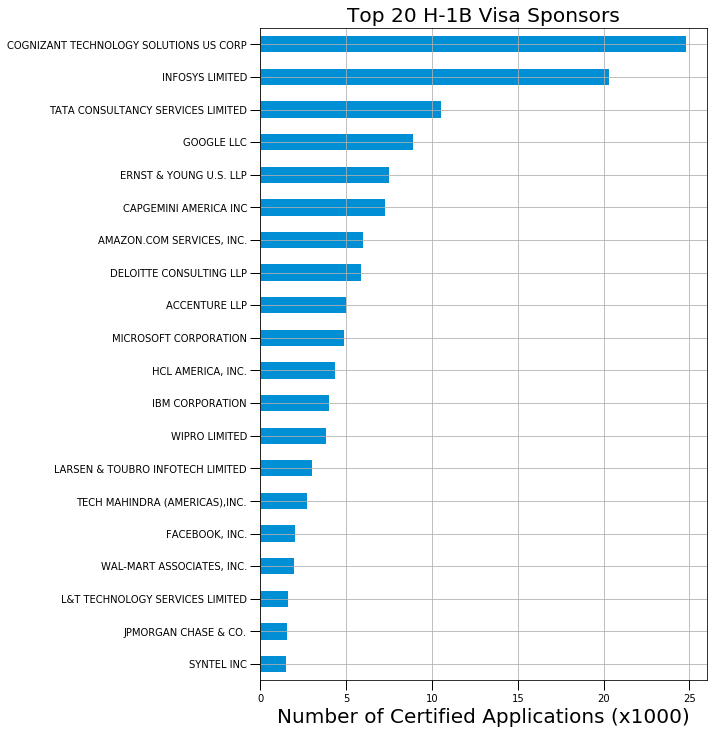

In [10]:
#Top 20 sponser companies
h1b_1=h1b[h1b['CASE_STATUS']=='CERTIFIED' ]
employer_name = h1b_1['EMPLOYER_NAME'].value_counts().index.tolist()
employer_certified = h1b_1['EMPLOYER_NAME'].value_counts().tolist()
df_employer = h1b_1['EMPLOYER_NAME'].value_counts().to_frame().head(20)
df_employer = df_employer.reset_index()
df_employer.columns = ['EMPLOYER_NAME','H1B_COUNT']
fig, ax = plt.subplots()# figsize=(8,4))
s = df_employer.set_index('EMPLOYER_NAME')['H1B_COUNT']
plt.style.use('fivethirtyeight')
ax = s.plot(kind='barh', figsize=(8, 12), 
            title='Top 20 H-1B Visa Sponsors')
ax.set_ylabel('', visible=False)
ax.tick_params(direction='out', length=10, width=1)
ax.invert_yaxis()
def thousand(x, pos):
    return '%1.0f' % (x*1e-3)
formatter = FuncFormatter(thousand)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Number of Certified Applications (x1000)',size=20)

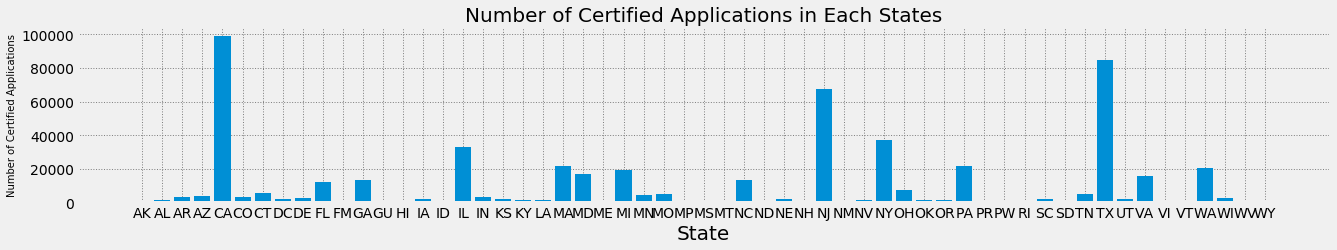

In [11]:
#number of certified applications in each states
df1=h1b_1.groupby('EMPLOYER_STATE').count()
plt.figure(figsize=(20, 3)) 
plt.bar(df1.index.values, df1.iloc[:,1].values)
plt.xlabel('State',size=20)
plt.ylabel('Number of Certified Applications',size=10)
plt.title('Number of Certified Applications in Each States',size=20)
plt.grid(linestyle=":", color="grey")

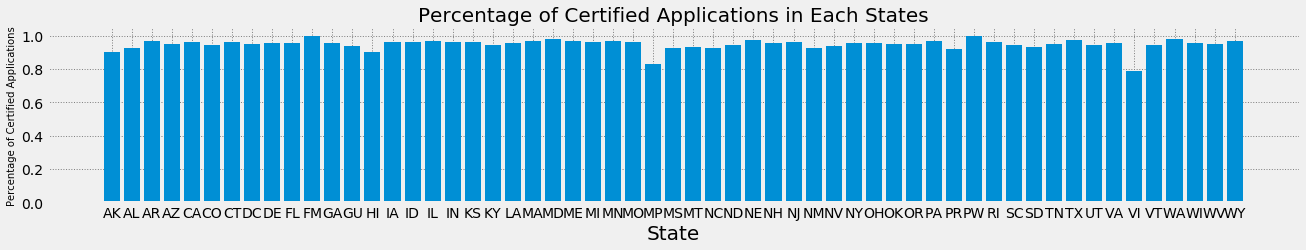

In [12]:
#percentage of certified applications in each states
df1=h1b.groupby('EMPLOYER_STATE').count()
df2=h1b_1.groupby('EMPLOYER_STATE').count()
df3=df2.iloc[:,1].values/df1.iloc[:,1].values
plt.figure(figsize=(20, 3)) 
plt.bar(df1.index.values, df3)
plt.xlabel('State',size=20)
plt.ylabel('Percentage of Certified Applications',size=10)
plt.title('Percentage of Certified Applications in Each States',size=20)
plt.grid(linestyle=":", color="grey")

Text(0.5, 1.0, 'Certified Applications Salary')

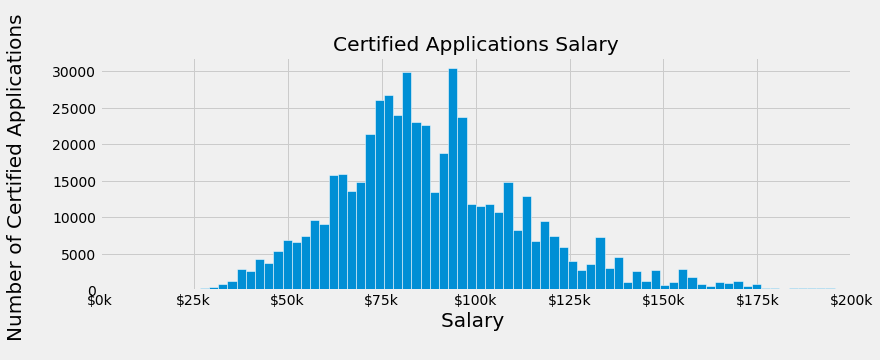

In [13]:
#number of certified applications in different salary
h1b_filtered = h1b_1[h1b_1['annual_salary']<1000000]
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.hist(h1b_filtered['annual_salary'],bins=200, edgecolor='white')
plt.xlim([0, 200000])

def thousandUSD(x, pos):
    return '$%1.0fk' % (x*1e-3)
def thousand(x, pos):
    return '%1.0f' % (x)
formatterUSD = FuncFormatter(thousandUSD)
formatter = FuncFormatter(thousand)

plt.xlabel('Salary \n',size=20)
plt.ylabel('Number of Certified Applications \n', size=20)
ax.xaxis.set_major_formatter(formatterUSD)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Certified Applications Salary')

Text(0.5, 1.0, 'Uncertified Applications Salary')

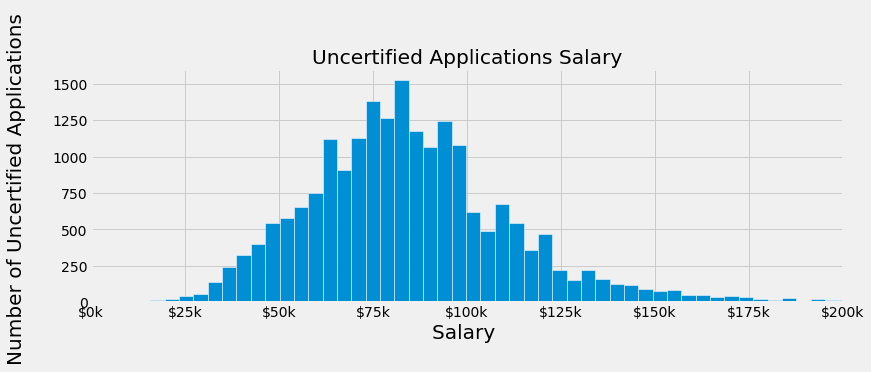

In [14]:
#number of uncertified applications in different salary
h1b_2=h1b[h1b['CASE_STATUS']!='CERTIFIED' ]
h1b_filtered2 = h1b_2[h1b_2['annual_salary']<1000000]
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.hist(h1b_filtered2['annual_salary'],bins=200, edgecolor='white')
plt.xlim([0, 200000])

def thousandUSD(x, pos):
    return '$%1.0fk' % (x*1e-3)
def thousand(x, pos):
    return '%1.0f' % (x)
formatterUSD = FuncFormatter(thousandUSD)
formatter = FuncFormatter(thousand)

plt.xlabel('Salary \n',size=20)
plt.ylabel('Number of Uncertified Applications \n ', size=20)
ax.xaxis.set_major_formatter(formatterUSD)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Uncertified Applications Salary')

# 3. Data Processing

## 3.1 Data for Weibull Model

In [15]:
#pick variables which will be used in timing model
df_time = h1b.loc[:, ['CASE_STATUS', 'VISA_CLASS', 'CASE_SUBMITTED', 'DECISION_DATE',
                'EMPLOYER_STATE', 'SECONDARY_ENTITY', 'AGENT_REPRESENTING_EMPLOYER',
               'TOTAL_WORKERS', 'NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT',
               'NEW_CONCURRENT_EMPLOYMENT', 'CHANGE_EMPLOYER','AMENDED_PETITION', 'FULL_TIME_POSITION', 'annual_salary']]


In [16]:
#define function to transform location
def region(state):
    WEST=["WA","OR","ID","MT","WY","CA","NV","UT","CO"]
    SOUTHWEST=["AZ","NM","OK","TX"]
    SOUTHEAST=["AR","LA","MS","AL","TN","KY","WV","DC","VA","NC","SC","GA","FL","MD","DE"]
    MIDWEST=["ND","SD","NE","KS","MN","IA","MO","WI","IL","IN","OH","MI"]
    NORTHEAST=["NY","VT","ME","NH","MA","RI","CT","NJ","DE","PA"]
    if state in WEST:
        return 'WEST'
    elif state in NORTHEAST:
        return 'NORTHEAST'
    elif state in SOUTHWEST:
        return 'SOUTHWEST'
    elif state in SOUTHEAST:
        return 'SOUTHEAST'
    elif state in MIDWEST:
        return 'MIDWEST'
    else:
        return 'NONCONTIGUOUS'

In [17]:
#change categoric variables into dummies
df_time['EMPLOYER_REGION'] = df_time['EMPLOYER_STATE'].apply(region)
df_time['SECONDARY_ENTITY'] = np.where(df_time['SECONDARY_ENTITY']=='Y', 1, 0)
df_time['AGENT_REPRESENTING_EMPLOYER'] = np.where(df_time['AGENT_REPRESENTING_EMPLOYER']=='Y', 1, 0)
df_time['FULL_TIME_POSITION'] = np.where(df_time['FULL_TIME_POSITION']=='Y', 1, 0)
employer_region = pd.get_dummies(df_time['EMPLOYER_REGION'])
visa = pd.get_dummies(df_time['VISA_CLASS'])
#certified = df_time['CERTIFIED']
df_time = pd.concat([df_time.iloc[:,0:-1], visa, employer_region], axis = 1)
#df_time['certified'] = certified

In [19]:
df_time.head()

,CASE_STATUS,VISA_CLASS,CASE_SUBMITTED,DECISION_DATE,EMPLOYER_STATE,SECONDARY_ENTITY,AGENT_REPRESENTING_EMPLOYER,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,...,E-3 Australian,H-1B,H-1B1 Chile,H-1B1 Singapore,MIDWEST,NONCONTIGUOUS,NORTHEAST,SOUTHEAST,SOUTHWEST,WEST
1,DENIED,H-1B,2018-11-19,2018-11-26,TX,0,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
2,DENIED,H-1B,2018-11-19,2018-11-26,TX,0,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
3,DENIED,H-1B,2018-12-22,2018-12-27,NC,0,0,1,1,0,...,0,1,0,0,0,0,0,1,0,0
4,CERTIFIED,H-1B,2019-03-22,2019-03-28,FL,0,0,1,1,0,...,0,1,0,0,0,0,0,1,0,0
5,DENIED,E-3 Australian,2019-03-07,2019-03-14,KY,0,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0


In [20]:
#save data for timing model
df_time.to_csv('timing.csv')

## 3.2 Data for Tree Classify and Random Forest Model

In [65]:
#pick variables which will be used in the model
h1b_c= h1b.loc[:,['CASE_STATUS', 'VISA_CLASS',
                'EMPLOYER_STATE', 'SECONDARY_ENTITY', 'AGENT_REPRESENTING_EMPLOYER',
               'TOTAL_WORKERS', 'NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT',
               'NEW_CONCURRENT_EMPLOYMENT', 'CHANGE_EMPLOYER','AMENDED_PETITION', 'FULL_TIME_POSITION', 'annual_salary']]
h1b_c.dropna(inplace = True)

In [66]:
#change categoric variables into dummies
h1b_c['CERTIFIED'] = np.where(h1b_c['CASE_STATUS']=='DENIED', 0, 1)
h1b_c['EMPLOYER_REGION'] = h1b_c['EMPLOYER_STATE'].apply(region)
h1b_c['SECONDARY_ENTITY'] = np.where(h1b_c['SECONDARY_ENTITY']=='Y', 1, 0)
h1b_c['AGENT_REPRESENTING_EMPLOYER'] = np.where(h1b_c['AGENT_REPRESENTING_EMPLOYER']=='Y', 1, 0)
h1b_c['FULL_TIME_POSITION'] = np.where(h1b_c['FULL_TIME_POSITION']=='Y', 1, 0)
employer_region = pd.get_dummies(h1b_c['EMPLOYER_REGION'])
visa = pd.get_dummies(h1b_c['VISA_CLASS'])


In [72]:
h1b_c.head()

,CASE_STATUS,VISA_CLASS,EMPLOYER_STATE,SECONDARY_ENTITY,AGENT_REPRESENTING_EMPLOYER,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,FULL_TIME_POSITION,annual_salary,CERTIFIED,EMPLOYER_REGION
1,DENIED,H-1B,TX,0,0,1,1,0,0,0,0,0,1,48630.0,0,SOUTHWEST
2,DENIED,H-1B,TX,0,0,1,1,0,0,0,0,0,1,79287.0,0,SOUTHWEST
3,DENIED,H-1B,NC,0,0,1,1,0,0,0,0,0,1,16536.0,0,SOUTHEAST
4,CERTIFIED,H-1B,FL,0,0,1,1,0,0,0,0,0,1,17596.8,1,SOUTHEAST
5,DENIED,E-3 Australian,KY,0,0,1,1,0,0,0,0,0,1,15080.0,0,SOUTHEAST


In [68]:
h1b_c.to_csv('tree.csv')

## 3.3 Data for Logistic Model and K-NN Model 

In [69]:
def ne_clean(d):
    if type(d) == str:
        if d.isdigit():
            return int(d)
        else:
            return float('nan')
    return d

In [70]:
#basic cleaning of the data
h1b_c1 = pd.concat([h1b_c.iloc[:,3:-1], visa, employer_region], axis = 1)
h1b_c1['CONTINUED_EMPLOYMENT'] = h1b_c1['CONTINUED_EMPLOYMENT'].apply(ne_clean)
h1b_c1['NEW_EMPLOYMENT'] = h1b_c1['NEW_EMPLOYMENT'].apply(ne_clean)
h1b_c1.dropna(subset = ['NEW_EMPLOYMENT'], inplace = True)
#h1b_c1.to_csv('h1b_cleaned.csv')
columns_names = list(h1b_c1.columns)

In [71]:
#use SMOTE to solve unbalance of the data
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=42)
target = h1b_c1['CERTIFIED']
feature = pd.concat([h1b_c1.iloc[:,:11],h1b_c1.iloc[:,12:]], axis = 1)

h1b_c1.shape
feature_smo, target_smo = smo.fit_sample(feature, target)

new_columns_names = columns_names[:11]
new_columns_names.extend(columns_names[12:])

h1b_smo=pd.DataFrame(feature_smo, columns = new_columns_names)
h1b_smo[columns_names[11]] = target_smo



In [73]:
h1b_smo.head()

,SECONDARY_ENTITY,AGENT_REPRESENTING_EMPLOYER,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,FULL_TIME_POSITION,...,H-1B,H-1B1 Chile,H-1B1 Singapore,MIDWEST,NONCONTIGUOUS,NORTHEAST,SOUTHEAST,SOUTHWEST,WEST,CERTIFIED
0,0,0,1,1.0,0.0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,0,0,1,1.0,0.0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,0,0,1,1.0,0.0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,1.0,0.0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1
4,0,0,1,1.0,0.0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [74]:
h1b_smo.to_csv('h1b_smote.csv')

# 4. Build Models

## 4.1 Weibull Model

In [41]:
#import and process data for timing model
df = pd.read_csv('timing.csv')
df.head(5)
df["censored"]=0
df["censored"][df["CASE_STATUS"]=="WITHDRAWN"]=1
df=df.astype({"DECISION_DATE":"datetime64","CASE_SUBMITTED":"datetime64"})
df=df.assign(days=(df["DECISION_DATE"]-df["CASE_SUBMITTED"]).dt.days.astype("int")+1)
df.iloc[:,:19]
df["annual_salary"]=df["annual_salary"].astype(int)


In [42]:
#variables
censor=df["censored"]
y=df["days"].values
x1=df["SOUTHWEST"]
x2=df["SECONDARY_ENTITY"]
x3=df["AGENT_REPRESENTING_EMPLOYER"]
x4=df["TOTAL_WORKERS"]
x7=df["CHANGE_PREVIOUS_EMPLOYMENT"]
x8=df["NEW_CONCURRENT_EMPLOYMENT"]
x9=df["CHANGE_EMPLOYER"]
x10=df["AMENDED_PETITION"]
x11=df["FULL_TIME_POSITION"]
x12=df["annual_salary"]
x13=df["NONCONTIGUOUS"]
x14=df["NORTHEAST"]
x15=df["SOUTHEAST"]
x5=df["WEST"]
x6=df["MIDWEST"]



In [43]:
#Weibull Model
def neg_LL(betas):
    alpha=np.exp(betas[0])
    alpha=alpha/np.exp(betas[1]*x1+betas[2]*x2+betas[3]*x3+betas[4]*x4+betas[5]*x5+betas[6]*x6+betas[7]*x7+betas[8]*x8+betas[9]*x9+betas[10]*x10+betas[11]*x11+betas[12]*x12+betas[13]*x13+betas[14]*x14+betas[15]*x15)
    gamma=np.exp(betas[16])
    c=np.exp(betas[17])
    ind_L1=(1-(alpha/(alpha+y**c))**gamma)-(1-(alpha/(alpha+(y-1)**c))**gamma)
    ind_L2=1-(1-(alpha/(alpha+y**c))**gamma)
    ind_L=ind_L1*(1-censor)+ind_L2*censor
    return -np.sum(np.log(ind_L))

guess=-np.random.rand(18)
model1=minimize(neg_LL,guess,method="BFGS")
print(model1.fun)

betas=model1.x
alpha=np.exp(betas[0])
gamma=np.exp(betas[16])
c=np.exp(betas[17])
print("alpha:", alpha,"gamma: ",gamma, "c:" ,c, "beta coefficients:", betas)



inf
alpha: 0.400217628521339 gamma:  0.3790518910829138 c: 0.859932149121666 beta coefficients: [-0.91574681 -0.98114371 -0.20118949 -0.11135875 -0.74816562 -0.85730886
 -0.22159937 -0.51861942 -0.14860669 -0.89086273 -0.98641118 -0.18574619
 -0.89003211 -0.0482965  -0.25907051 -0.61531246 -0.97008217 -0.15090179]


## 4.2 Logistic Model

In [66]:
#logistic model
df = pd.read_csv('h1b_smote.csv')

#shuffle the data
np.random.seed(40)
from sklearn.utils import shuffle
df=shuffle(df)

#split in training set and testing set
training=df[0:int(0.70*df.shape[0])]
testing=df[int(0.70*df.shape[0]):]

#apply logistic regression
from statsmodels.formula.api import logit
model=logit("CERTIFIED~SECONDARY_ENTITY+AGENT_REPRESENTING_EMPLOYER+TOTAL_WORKERS\
            +NEW_EMPLOYMENT+CONTINUED_EMPLOYMENT+CHANGE_PREVIOUS_EMPLOYMENT+\
            NEW_CONCURRENT_EMPLOYMENT+CHANGE_EMPLOYER+AMENDED_PETITION+FULL_TIME_POSITION\
            +annual_salary+MIDWEST+NONCONTIGUOUS+NORTHEAST+SOUTHEAST+SOUTHWEST",data=training).fit()
#+WEST
model.summary()


Optimization terminated successfully.
         Current function value: 0.632303
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              CERTIFIED   No. Observations:               786615
Model:                          Logit   Df Residuals:                   786598
Method:                           MLE   Df Model:                           16
Date:                Sun, 08 Dec 2019   Pseudo R-squ.:                 0.08778
Time:                        20:40:27   Log-Likelihood:            -4.9738e+05
converged:                       True   LL-Null:                   -5.4524e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.3844      0.018   -134.662      0.000      -2.419      -2.350
SECONDARY_ENTITY                1.4571      0.006    229.124      0.000       1.445       1.470
AGENT_REPRESENTING_EMPLOYER     0.6530      0.006    108.035      0.000       0.641       0.665
TOTAL_WORKERS                  -0.0926      0.003    -33.189      0.000      -0.098      -0.087
NEW_EMPLOYMENT                  0.0816      0.003     27.011      0.000       0.076       0.088
CONTINUED_EMPLOYMENT            0.0945      0.004     22.563      0.000       0.086       0.103
CHANGE_PREVIOUS_EMPLOYMENT      0.2012      0.006     35.654      0.000       0.190       0.212
NEW_CONCURRENT_EMPLOYMENT      -0.3917      0.017    -23.321      0.000      -0.425      -0.359
CHANGE_EMPLOYER                -0.0107      0.002     -6.395      0.000      -0.014      -0.007
AMENDED_PETITION                0.1442      0.007     22.122      0.000       0.131       0.157
FULL_TIME_POSITION              1.6063      0.017     96.943      0.000       1.574       1.639
annual_salary               -3.239e-08   2.09e-09    -15.518      0.000   -3.65e-08   -2.83e-08
MIDWEST                         0.1127      0.009     12.957      0.000       0.096       0.130
NONCONTIGUOUS                  -2.2073      0.055    -39.864      0.000      -2.316      -2.099
NORTHEAST                      -0.0819      0.007    -11.704      0.000      -0.096      -0.068
SOUTHEAST                      -0.1002      0.008    -12.239      0.000      -0.116      -0.084
SOUTHWEST                       0.3255      0.009     36.638      0.000       0.308       0.343
===============================================================================================
"""

In [18]:
Prediction_tag = [1 if i >0.65 else 0 for i in Prediction]

In [59]:
sum(Prediction_tag)

73905

[[151661  17062]
 [111555  56843]]


Text(30.5, 0.5, 'true')

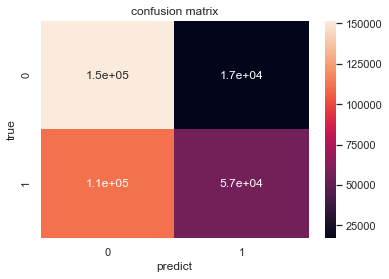

In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(testing['CERTIFIED'], Prediction_tag, labels=[0, 1])
print(C2) 
sns.heatmap(C2,annot=True,ax=ax) 

ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 

In [4]:
#calculate the accuracy of the testing data
y_testing=testing['CERTIFIED'].values
Prediction=model.predict(testing)
Accuracy=np.mean((y_testing-Prediction)**2)
print(Accuracy)

0.2209154848868441


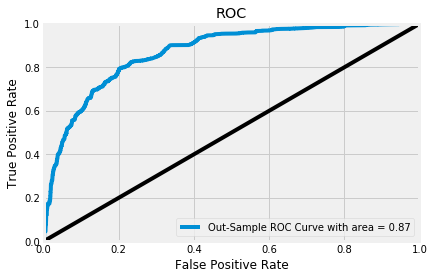

0.8688321540766506

In [81]:
#print ROC curve and calculate auc score
from sklearn.metrics import roc_curve, auc
(fpr, tpr, thresholds) = roc_curve(y_testing,Prediction)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import roc_auc_score
roc_auc_score(y_testing,Prediction)

## 4.3 K-NN Model

In [69]:
h1b_smo = pd.read_csv('h1b_smote.csv')

In [77]:
h1b_smo

,Unnamed: 0,SECONDARY_ENTITY,AGENT_REPRESENTING_EMPLOYER,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,...,H-1B,H-1B1 Chile,H-1B1 Singapore,MIDWEST,NONCONTIGUOUS,NORTHEAST,SOUTHEAST,SOUTHWEST,WEST,CERTIFIED
0,0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0
1,1,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0
2,2,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0
3,3,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1
4,4,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0
5,5,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0
6,6,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1
7,7,0.000000,0.000000,10.000000,10.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0
8,8,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0
9,9,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1


In [70]:
#K-NN model
from sklearn.utils import shuffle
np.random.seed(30)
knn=shuffle(h1b_smo)

#pick part of the data
knn=knn.iloc[0:10000,:]

knn_train=knn[0:int(0.70*knn.shape[0])]
knn_test=knn[int(0.70*knn.shape[0]):]


In [71]:
#normalization
from sklearn.preprocessing import StandardScaler 

scaler=StandardScaler()
scaler.fit(knn_train.iloc[:,0:-1])
#print(scaler.mean_)
#print(scaler.var_)
knn_train_s= scaler.transform(knn_train.iloc[:,0:-1])
knn_test_s=scaler.transform(knn_test.iloc[:,0:-1])
#np.mean(T_train_s,axis=0)
#np.var(T_train_s,axis=0)
#np.mean(T_valid_s,axis=0)
#np.var(T_valid_s,axis=0)

In [72]:
#run the model on test data 
from sklearn.neighbors import KNeighborsClassifier

model= KNeighborsClassifier(n_neighbors=10, weights ="uniform")

model.fit(knn_train_s[:,0:-1],knn_train.iloc[:,-1])

prediction= model.predict(knn_test_s[:,0:-1])


In [73]:
#calculate the accuracy of the testing data
y_testing=knn_test['CERTIFIED'].values
Accuracy=np.mean((y_testing-prediction)**2)
print(Accuracy)

0.043666666666666666


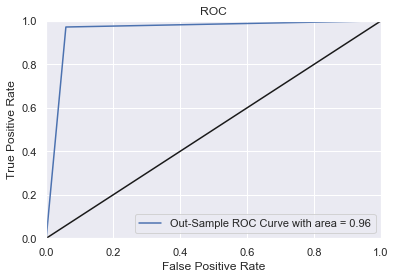

0.9564757641110071

In [74]:
#print ROC curve and calculate auc score
from sklearn.metrics import roc_curve, auc
(fpr, tpr, thresholds) = roc_curve(y_testing,prediction)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import roc_auc_score
roc_auc_score(y_testing,prediction)

[[1425   89]
 [  42 1444]]


Text(30.5, 0.5, 'true')

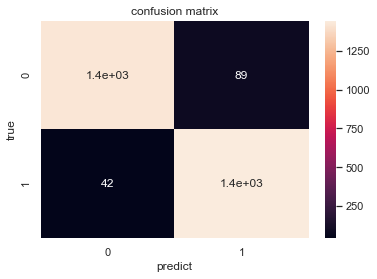

In [75]:
#get confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(y_testing, prediction, labels=[0, 1])
print(C2) 
sns.heatmap(C2,annot=True,ax=ax) 

ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 



## 4.4 Tree Classify


In [28]:
df.columns

Index(['Unnamed: 0', 'SECONDARY_ENTITY', 'AGENT_REPRESENTING_EMPLOYER',
       'TOTAL_WORKERS', 'NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT',
       'CHANGE_PREVIOUS_EMPLOYMENT', 'NEW_CONCURRENT_EMPLOYMENT',
       'CHANGE_EMPLOYER', 'AMENDED_PETITION', 'FULL_TIME_POSITION',
       'annual_salary', 'CERTIFIED', 'E-3 Australian', 'H-1B', 'H-1B1 Chile',
       'H-1B1 Singapore', 'MIDWEST', 'NONCONTIGUOUS', 'NORTHEAST', 'SOUTHEAST',
       'SOUTHWEST', 'WEST'],
      dtype='object')

In [44]:
#logistic model
#df = pd.read_csv('h1b_cleaned.csv')
#df['CASE_STATUS']=(df['CASE_STATUS']=='CERTIFIED')*1
#df=df.drop(labels=['Unnamed: 0','NEW_EMPLOYMENT','CONTINUED_EMPLOYMENT','CASE_STATUS','EMPLOYER_STATE','VISA_CLASS','EMPLOYER_REGION'],axis=1)

#shuffle the data
np.random.seed(40)
from sklearn.utils import shuffle
df=shuffle(df)

#split in training set and testing set
training=df[0:int(0.70*df.shape[0])]
testing=df[int(0.70*df.shape[0]):]



In [37]:
sum(testing['CERTIFIED'])

168608

In [40]:
df = pd.read_csv('h1b_smote.csv')

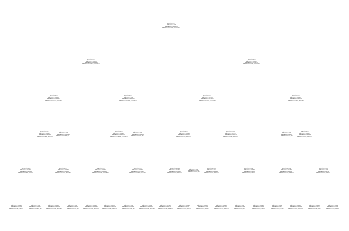

In [45]:
#apply tree classify
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import plot_tree

training_target = training['CERTIFIED']
training_feature = training.drop(columns = ['Unnamed: 0', 'CERTIFIED'])
testing_target = testing['CERTIFIED']
testing_feature = testing.drop(columns = ['Unnamed: 0', 'CERTIFIED'])
model=DecisionTreeClassifier(max_depth=5)
model.fit(training_feature, training_target)
Prediction=model.predict(testing_feature)

plot_tree(model)
plt.show()

#calculate the accuracy of the testing data
#y_testing=testing['CERTIFIED'].values
#print(np.mean((y_testing-Prediction)**2))

[[107386  61337]
 [   769 167629]]


Text(30.5, 0.5, 'true')

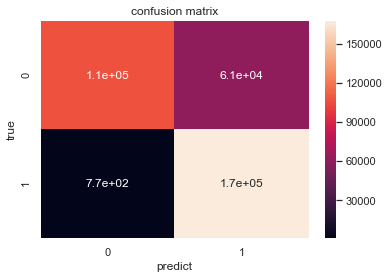

In [46]:
#get confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(testing_target.values, Prediction, labels=[0, 1])
print(C2) 
sns.heatmap(C2,annot=True,ax=ax) 

ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 


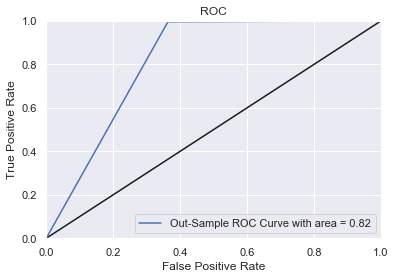

0.8159483765318652

In [47]:
#print ROC curve and calculate auc score
from sklearn.metrics import roc_curve, auc
(fpr, tpr, thresholds) = roc_curve(testing_target.values,Prediction)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import roc_auc_score
roc_auc_score(testing_target.values,Prediction)

## 4.5 Random Forest

In [55]:
#random forest
from sklearn.ensemble import RandomForestClassifier
#n_estimators: The number of trees in the forest.
model=RandomForestClassifier(n_estimators=1000, max_depth=5,max_features=5,bootstrap=True)
model.fit(training_feature, training_target)
Prediction=model.predict(testing_feature)

#calculate the accuracy of the testing data
#prediction=model.predict(testing.iloc[:,0:-1])
#print(np.mean(((y_testing-prediction))**2))

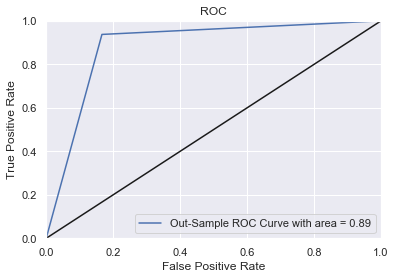

0.8855690269192384

In [56]:
#print ROC curve and calculate auc score
from sklearn.metrics import roc_curve, auc
(fpr, tpr, thresholds) = roc_curve(testing_target.values,Prediction)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import roc_auc_score
roc_auc_score(testing_target.values,Prediction)

[[140634  28089]
 [ 10505 157893]]


Text(30.5, 0.5, 'true')

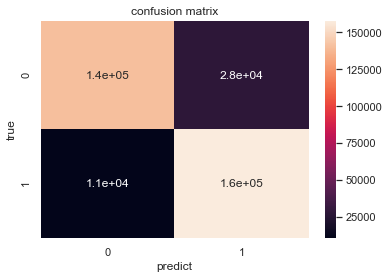

In [57]:
#get confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(testing_target, Prediction, labels=[0, 1])
print(C2) 
sns.heatmap(C2,annot=True,ax=ax) 

ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 